In [1]:
import pandas as pd
from tqdm import tqdm

# Import package
import os, sys
parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
from src.exchange import TOB_Exchange

%load_ext autoreload 
%autoreload 2

## Load data

In [111]:

folder_path = '/Users/jan-gobeli/Code/bi-repo/data/tardis/datasets/'
files_list = [
    f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) 
    and f.split('_')[0] == 'binance' 
    and f.split('_')[-1] == 'COMPBTC.csv.gz'
    and f.split('_')[1] == 'quotes']

tfiles_list = [
    f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) 
    and f.split('_')[0] == 'binance' 
    and f.split('_')[-1] == 'COMPBTC.csv.gz'
    and f.split('_')[1] == 'trades']

ufiles_list = [
    f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) 
    and f.split('_')[0] == 'upbit' 
    and f.split('_')[-1] == 'BTC-COMP.csv.gz'
    and f.split('_')[1] == 'quotes']

utfiles_list = [
    f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) 
    and f.split('_')[0] == 'upbit' 
    and f.split('_')[-1] == 'BTC-COMP.csv.gz'
    and f.split('_')[1] == 'trades']

In [112]:
def get_data(files_list):
    df = pd.DataFrame()
    # Use a loop to get all the csv.gz files from the path location in a single Dataframe
    for csv_file in tqdm(files_list):
        file_name = (folder_path + csv_file)
        if file_name[-2:] == "gz":
            df1 = pd.read_csv(file_name, compression='gzip')
            # Concatenate all the dataframes into a single dataframe
            df = pd.concat([df, df1], ignore_index=True)

    df['time'] = pd.to_datetime(df.timestamp, unit='us')
    df.set_index('time', inplace=True)
    df.sort_index(inplace=True)
    return df

In [113]:
upbit_data = get_data(ufiles_list)
binance_data = get_data(files_list)

upbit_trades_data = get_data(utfiles_list)
binance_trades_data = get_data(tfiles_list)

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 54.21it/s]


In [118]:
binance_lst = binance_data[['timestamp', 'bid_amount', 'bid_price', 'ask_price', 'ask_amount']].sort_values('timestamp').to_numpy()
binance_trades_lst = binance_trades_data[['timestamp', 'id', 'side', 'price', 'amount']].to_numpy()
upbit_lst = upbit_data[['timestamp', 'bid_amount', 'bid_price', 'ask_price', 'ask_amount']].sort_values('timestamp').to_numpy()
upbit_trades_lst =  upbit_trades_data[['timestamp', 'id', 'side', 'price', 'amount']].to_numpy()

In [122]:
base = 'COMP'
quote = 'BTC'
symbol = base + quote

hedging = TOB_Exchange(latency=[5000, 0.29])
hedging.add_market(symbol, base, quote)
hedging.add_balance(base, 0)
hedging.add_balance(quote, 0.173)
hedging.load_tob(binance_lst, symbol)
hedging.load_trades(binance_trades_lst, symbol)

In [123]:
origin = TOB_Exchange(latency=[5000, 0.29])
origin.add_market(symbol, base, quote)
origin.add_balance(base, 100)
origin.add_balance(quote, 0)
origin.load_tob(upbit_lst, symbol)
origin.load_trades(upbit_trades_lst, symbol)

In [99]:
class cross_exchange(): 
    def __init__(self):
        self.symbol = 'COMPBTC'
        self.amount = 1

        self.distance = 200 / 10_000 # place orders at 10bps distance
        self.sensitivity =  100 / 10_000 # after a move of 4bps, replace the order

        self.last_trade = None

        self.timestamp = None

        self.current_bid = None 
        self.current_ask = None

        self.hedging_ask = None 
        self.hedging_bid = None

        self.bid_open = None 
        self.ask_open = None


        self.initial_sell = False
        self.initial_buy = False

        self.counter = 0
        self.balances = []

    def run_strategy(self):

        hedging_tob = hedging.fetch_tob(self.symbol)
        origin_tob = origin.fetch_tob(self.symbol)
        self.current_ask = origin_tob['ask_price']
        self.current_bid = origin_tob['bid_price']
        self.hedging_ask = hedging_tob['ask_price']
        self.hedging_bid = hedging_tob['bid_price']

        self.timestamp = max(origin_tob['timestamp'], hedging_tob['timestamp'])

        # If a trade was executed on the origin, make a market order on the hedging exchange
        if len(origin.trades) > 0: 
            if origin.trades[-1] != self.last_trade:
                self.last_trade = origin.trades[-1]

                if self.last_trade.side: 
                    side = 0 
                    self.initial_buy = False

                else: 
                    side = 1
                    self.initial_sell = False

                print('hedging')
                hedging.market_order(self.symbol, self.amount, side, self.timestamp)

        # Open orders if they currently arent open
        if len(origin.open_orders[self.symbol][0]) == 0 and not self.initial_sell: 
            print(f'Sell {self.amount} @ {self.hedging_ask * (1 + self.distance)} with {self.hedging_ask}')
            origin.limit_order(
                self.symbol, self.amount, self.hedging_ask * (1 + self.distance), 0, self.timestamp
            )
            self.ask_open = self.hedging_ask
            self.initial_sell = True

        # if the price moved too much, replace the order
        elif (abs(self.ask_open / self.hedging_ask) - 1 > self.sensitivity) and (len(origin.open_orders[self.symbol][0]) > 0): 
            print(f'Replacing sell {self.amount} @ {self.hedging_ask * (1 + self.distance)} with {self.hedging_ask}')
            origin.cancel_order(origin.open_orders[self.symbol][0].peekitem(0)[1])
            origin.limit_order(
                self.symbol, self.amount, self.hedging_ask * (1 + self.distance), 0, self.timestamp
            )
            self.ask_open = self.hedging_ask

        if len(origin.open_orders[self.symbol][1]) == 0 and not self.initial_buy: 
            print(f'Buy {self.amount} @ {self.hedging_bid * (1 - self.distance)} with {self.hedging_bid}')
            origin.limit_order(
                self.symbol, self.amount, self.hedging_bid * (1 - self.distance), 1, self.timestamp
            )
            self.bid_open = self.hedging_bid
            self.initial_buy = True

        # if the price moved too much, replace the order
        elif (abs(self.bid_open / self.hedging_ask) - 1 > self.sensitivity) and (len(origin.open_orders[self.symbol][1]) > 0): 
            print(f'Replacing buy {self.amount} @ {self.hedging_bid * (1 - self.distance)} with {self.hedging_bid}')
            origin.cancel_order(origin.open_orders[self.symbol][1].peekitem(0)[1])
            origin.limit_order(
                self.symbol, self.amount, self.hedging_bid * (1 - self.distance), 0, self.timestamp
            )
            self.bid_open = self.hedging_bid


        # Run the simulation step in the place where we are behind
        if hedging_tob['timestamp'] > origin_tob['timestamp']: 
            origin._simulation_step()
        else: 
            hedging._simulation_step()

    def run_simulation(self):
        while (len(origin.events) > 0) and (len(hedging.events) > 0): 
            self.run_strategy()

            self.counter += 1
            if self.counter % 100:
                update = origin.balance.copy()
                u_2 = hedging.balance.copy()

                update['BTC_hedging'] = u_2['BTC']
                update['COMP_hedging'] = u_2['COMP']
                update["mid"] = (
                    self.hedging_ask + self.hedging_bid
                ) / 2
                update["ts"] = self.timestamp

                self.balances.append(update)

In [100]:
strategy = cross_exchange()

In [101]:
strategy.run_simulation()

Sell 1 @ 0.00175032 with 0.001716
Buy 1 @ 0.0016806999999999998 with 0.001715
Replacing sell 1 @ 0.00173298 with 0.001699
Replacing sell 1 @ 0.0017156399999999998 with 0.001682
Trade Executed Trade(trade_id=387, order_id=494, side=0, taker=False, amount=1, price=0.0017156399999999998, entryTime=1688264320404458.8, eventTime=1688266094461000.0)
hedging
Sell 1 @ 0.0017421600000000002 with 0.001708
Trade Executed Trade(trade_id=388, order_id=495, side=1, taker=True, amount=1, price=0.001708, entryTime=1688266094746637.8, eventTime=1688266094746637.8)
Replacing sell 1 @ 0.00172482 with 0.001691
Replacing sell 1 @ 0.00170748 with 0.001674
Trade Executed Trade(trade_id=389, order_id=498, side=0, taker=False, amount=1, price=0.00170748, entryTime=1688270302964052.2, eventTime=1688273881732000.0)
hedging
Sell 1 @ 0.00176358 with 0.001729
Trade Executed Trade(trade_id=390, order_id=499, side=1, taker=True, amount=1, price=0.001728, entryTime=1688273881743896.0, eventTime=1688273881743896.0)
Tra

In [102]:
bal = pd.DataFrame(strategy.balances)

In [103]:
bal['comp_usd'] = bal.COMP * bal.mid
bal['comp_usd_hedging'] = bal.COMP_hedging * bal.mid
bal['combined'] = bal.comp_usd + bal.BTC
bal['combined_hedging'] = bal.comp_usd_hedging + bal.BTC_hedging

In [106]:
bal

,COMP,BTC,BTC_hedging,COMP_hedging,mid,ts,comp_usd,comp_usd_hedging,combined,combined_hedging
0,100,0.000000,0.173000,0,0.001716,1.688256e+15,0.17155,0.000000,0.171550,0.173000
1,100,0.000000,0.173000,0,0.001716,1.688256e+15,0.17155,0.000000,0.171550,0.173000
2,100,0.000000,0.173000,0,0.001716,1.688256e+15,0.17155,0.000000,0.171550,0.173000
3,100,0.000000,0.173000,0,0.001716,1.688256e+15,0.17155,0.000000,0.171550,0.173000
4,100,0.000000,0.173000,0,0.001716,1.688256e+15,0.17155,0.000000,0.171550,0.173000
...,...,...,...,...,...,...,...,...,...,...
879617,0,0.197037,0.000929,89,0.001948,1.688602e+15,0.00000,0.173372,0.197037,0.174301
879618,0,0.197037,0.000929,89,0.001948,1.688602e+15,0.00000,0.173372,0.197037,0.174301
879619,0,0.197037,0.000929,89,0.001948,1.688602e+15,0.00000,0.173372,0.197037,0.174301
879620,0,0.197037,0.000929,89,0.001948,1.688602e+15,0.00000,0.173372,0.197037,0.174301


<Axes: >

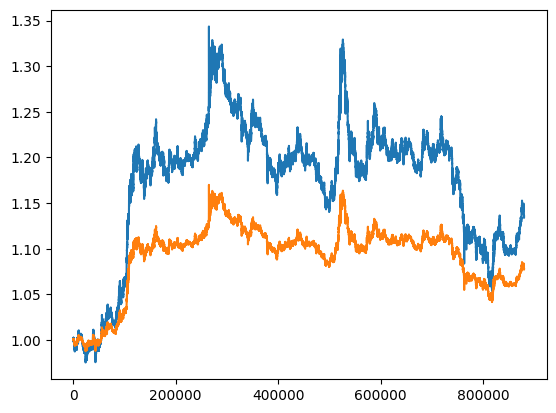

In [104]:
(1 + bal.mid.pct_change()).cumprod().plot()
(1+(bal.combined + bal.combined_hedging).pct_change()).cumprod().plot()

<Axes: >

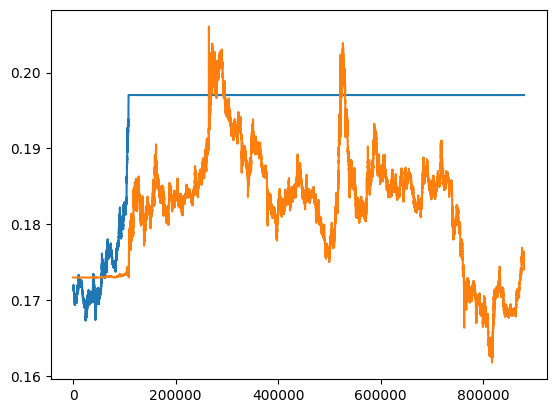

In [105]:
bal.combined.plot()
bal.combined_hedging.plot()